<a href="https://colab.research.google.com/github/ipeirotis/mturk_demographics/blob/master/5_Estimating_Propensity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Loading data

Below we have the code that retrieves the data from the  Mechanical Turk Tracker Demographics API.

In [1]:
import pandas as pd
URL = 'https://github.com/ipeirotis/mturk_demographics/raw/master/dataset_29may2023_16_mar2015.zip'
df = pd.read_csv(URL, low_memory=False)
# df.drop(df.columns[0], axis=1, inplace=True) # drop the "index" column
# # We now transform our API answer into a flat table

# # Convert all NaN values to None
# df = df.where(pd.notnull(df), None)

# df['hit_answered_date'] = pd.to_datetime(df['hit_answered_date'])
# df['hit_creation_date'] = pd.to_datetime(df['hit_creation_date'])
# df["post_to_completion_secs"] = (df['hit_answered_date'] - df['hit_creation_date']).dt.seconds

# df["household_income"]=df["household_income"].astype("category")
# df["household_size"]=df["household_size"].astype("category")
# df["location_country"]=df["location_country"].astype("category")
# df["marital_status"]=df["marital_status"].astype("category")
# df['date'] = pd.to_datetime(df['hit_answered_date'].apply(lambda x : x.date()))
# df['time'] = df['hit_answered_date'].dt.round('min').apply(lambda x : x.time())
# df.dtypes

df.drop(df.columns[0], axis=1, inplace=True) # drop the "index" column
# We now transform our API answer into a flat table
# and set the right data types
df["hit_answered_date"]=pd.to_datetime(df["hit_answered_date"])
df["hit_creation_date"]=pd.to_datetime(df["hit_creation_date"])
df["household_income"]=df["household_income"].astype("category")
df["household_size"]=df["household_size"].astype("category")
df["location_country"]=df["location_country"].astype("category")
df["marital_status"]=df["marital_status"].astype("category")
df['date'] = pd.to_datetime(df['hit_answered_date'].apply(lambda x : x.date()))
df['time'] = df['hit_answered_date'].dt.round('min').apply(lambda x : x.time())
df.dtypes

time                                     object
hit_answered_date           datetime64[ns, UTC]
worker_id                                object
hit_creation_date           datetime64[ns, UTC]
gender                                   object
household_size                         category
household_income                       category
marital_status                         category
year_of_birth                           float64
time_spent_on_mturk                      object
languages_spoken                         object
weekly_income_from_mturk                 object
educational_level                        object
location_country                       category
location_region                          object
location_city                            object
date                             datetime64[ns]
dtype: object

In [2]:
import datetime
from dateutil.relativedelta import relativedelta
minDate = min(df['hit_answered_date'])
maxDate = max(df['hit_answered_date'])
days = (maxDate - minDate).days
# Calculate the difference between the dates using relativedelta
date_difference = relativedelta(maxDate, minDate)

# Calculate the total months difference
total_months = date_difference.years * 12 + date_difference.months

print(minDate)
print(maxDate)
print(days)
print(total_months)

2015-03-16 18:52:03.956000+00:00
2023-05-30 01:48:36.508000+00:00
2996
98


In [3]:
from time import gmtime, strftime
def t():
    print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))


### Exploratory plots

In [4]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
mpl.rc("figure", figsize=(16, 8))
mpl.rcParams.update({'font.size': 22})

### New Worker IDs discovered

In [5]:
def getWorkerIDs(df, startDate, endDate):
    '''
    Returns the set of distinct workers that participated in the surveys between the two dates
    '''
    workers = df["worker_id"][(df['hit_answered_date']>=startDate) & (df['hit_answered_date']<endDate)]
    unique = set(workers)
    return {
        "workers": len(workers),
        "unique": len(unique),
        "ratio": (len(unique) +0.5) / (len(workers) + 0.5),
        "start": startDate,
        "end": endDate
    }

In [6]:
dates = sorted(set(df['date']))
len(dates)

2905

In [7]:
minDate

Timestamp('2015-03-16 18:52:03.956000+0000', tz='UTC')

In [8]:
import pytz
from datetime import date, time, datetime
dates = sorted(set(df['date']))
given_time = time(0, 0, 0, 0)  # Hours, minutes, seconds, microseconds

results = []
for d in dates:
   # Combine date and time to create a datetime object
    combined_datetime = datetime.combine(d, given_time)
    # Set the timezone for the combined datetime (e.g., UTC)
    combined_datetime_with_timezone = pytz.utc.localize(combined_datetime)
    result = getWorkerIDs(df, minDate, pd.Timestamp(combined_datetime_with_timezone))
    results.append( result )

<Axes: xlabel='end'>

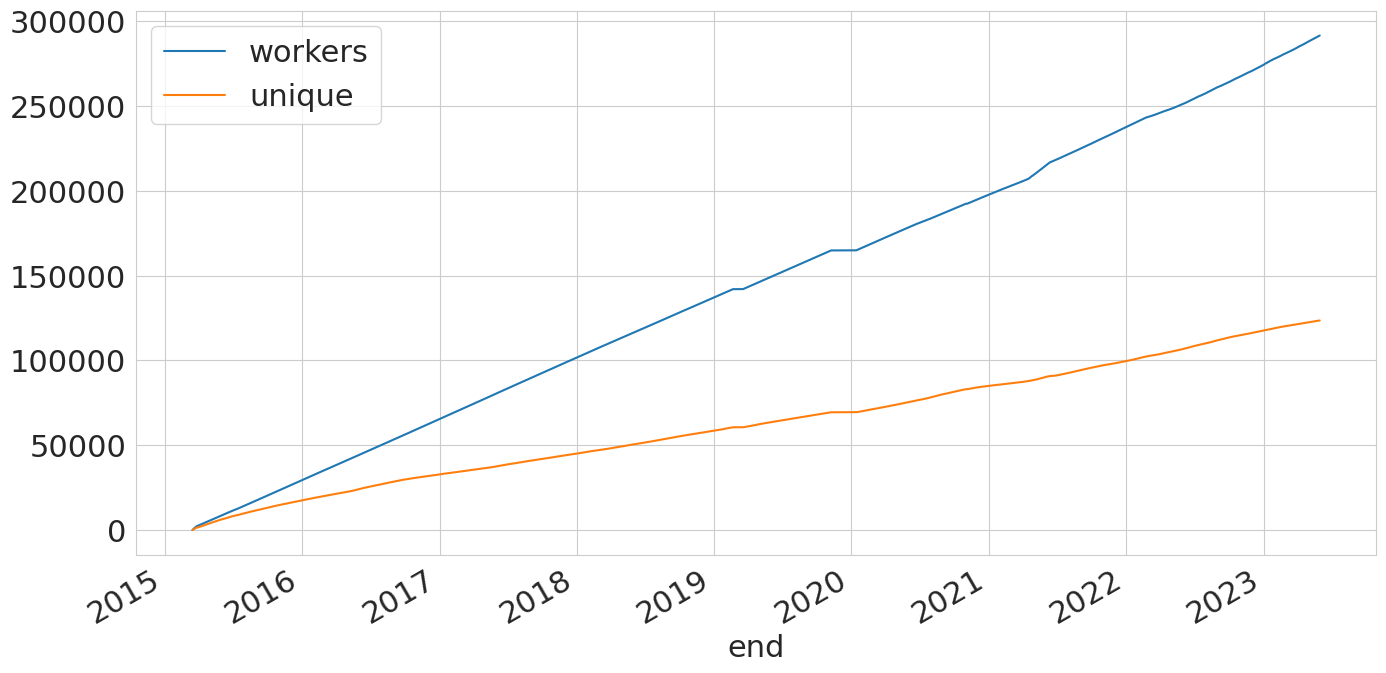

In [9]:
workers = pd.DataFrame(results)
workers.set_index('end', inplace = True)
workers[ ['workers', 'unique'] ].plot()

<Axes: xlabel='end'>

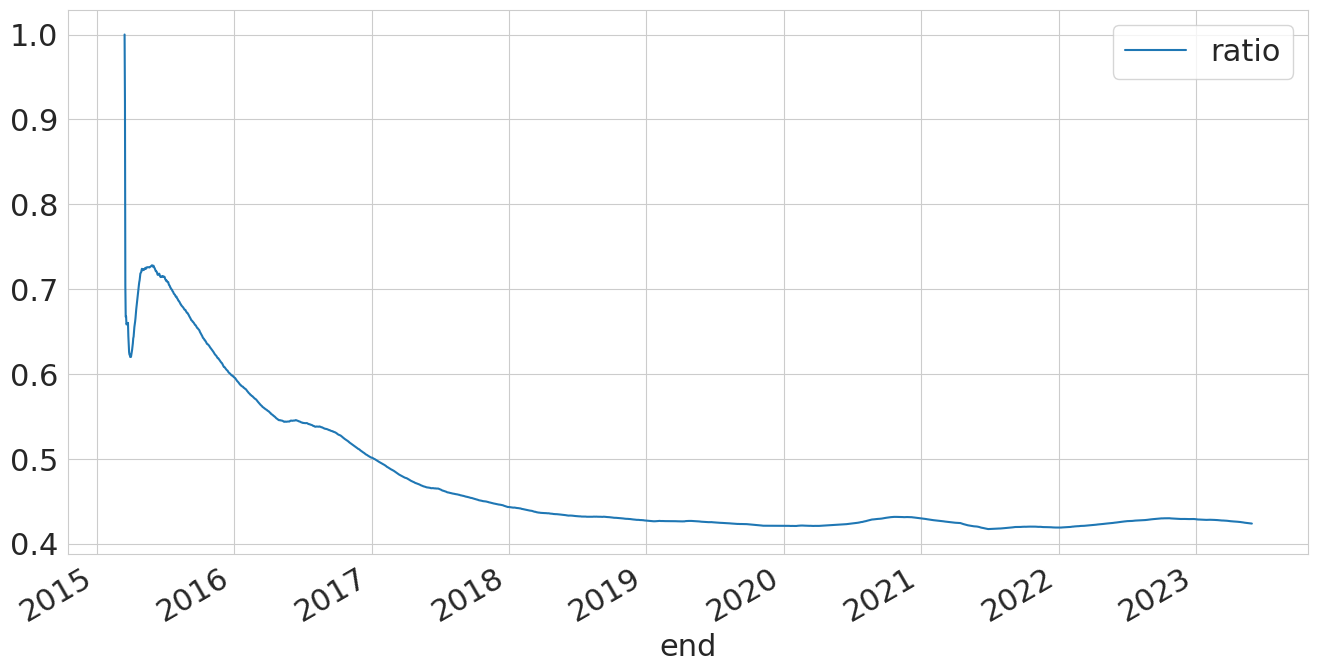

In [10]:
workers[ ['ratio'] ].plot()

### Selection bias

The analysis above indicated that we should expect to see around 10K-15K workers on Mechanical Turk, with an average half-life of around a year and a half. Over the last two years, this means around 35K-40K workers total.

Out of these workers , every month, we survey around $24*4*30 \approx 3K$ workers, for a total of around 80K surveys so far.

If every worker had uniform chance of participating, we would have expected that on average we would see each worker twice.





In [11]:
len(df)

291458

In [12]:
s = pd.DataFrame(df['worker_id'].value_counts()).cumsum()['worker_id'].values/len(df)
sum(s<0.5)/len(df)

0.05355488612424432

In [13]:
pd.DataFrame(df['worker_id'].value_counts()).head(5)

,worker_id
MTnL4pK3QezPpfLZZqNfgyERy1w5vsTph8bj8XxdvAA=,92
QEnrfikvIRDKUhzaqxMDohvMU4VO4T3BIc6RGykyABs=,91
st91SPN5WVyhhKTlNvyt/wZPhp585ctyQYtPxqocsWo=,90
8GHkSBMoEXeFRwEFlWOdSgMJ9DgE2HyaoQzbjiwAAX8=,87
rCkQ2NdOt2tH+8/wbYeQMlKgnSWlIim6rYrJni7p1lQ=,81


In [14]:
df.set_index('worker_id')

,time,hit_answered_date,hit_creation_date,gender,household_size,household_income,marital_status,year_of_birth,time_spent_on_mturk,languages_spoken,weekly_income_from_mturk,educational_level,location_country,location_region,location_city,date
worker_id,,,,,,,,,,,,,,,,
GIQvi1p3x6/xUloDxpXza3DJKzO9QxtN0yPb49FMiY8=,14:40:00,2020-11-07 14:40:08.402000+00:00,2020-11-07 13:33:01+00:00,male,2,"$25,000-$39,999",married,1982.0,2-4 hours per week,"English,Tamil",$10-$20 per week,"Graduate degree, Masters",ZZ,NaN,NaN,2020-11-07
OuVAI9jQUJ1TrM8tfCrr70KsearC0kNbovFD9prQ91M=,09:06:00,2020-11-13 09:05:39.583000+00:00,2020-11-13 08:48:01+00:00,male,3,"$40,000-$59,999",married,1930.0,2-4 hours per week,English,$50-$100 per week,Bachelors degree,ZZ,NaN,NaN,2020-11-13
rXYK7nenLvxPYqFIOk9Ik5ALPFsXma+Lah1+1Ct+5y4=,01:24:00,2020-11-07 01:24:09.740000+00:00,2020-11-07 00:33:01+00:00,female,2,"$40,000-$59,999",single,1994.0,4-8 hours per week,English,$20-$50 per week,"Some college, no degree",ZZ,NaN,NaN,2020-11-07
ndej+ke5aXKdkZmPuI2Vz878ZjtyA4r2+7D4zA05Pvw=,03:51:00,2020-11-06 03:50:54.902000+00:00,2020-11-06 03:18:00+00:00,male,4,"$75,000-$99,999",married,1991.0,2-4 hours per week,"English,Malayalam,Tamil",$20-$50 per week,"Graduate degree, Masters",ZZ,NaN,NaN,2020-11-06
E2skbsh2TBfWqeUSwFDajfQfJpMB2hqjKkzFh26W2PY=,15:42:00,2020-11-07 15:42:23.723000+00:00,2020-11-07 14:48:01+00:00,female,4,"$75,000-$99,999",married,1996.0,2-4 hours per week,"English,Tamil",$10-$20 per week,Bachelors degree,ZZ,NaN,NaN,2020-11-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
QTMSwD3FlJ6k9Zi0bBn7H0AarzqzXQKJkXhTjyNywpo=,17:44:00,2021-04-18 17:44:15.374000+00:00,2021-04-18 16:34:01+00:00,male,3,"$25,000-$39,999",single,1994.0,4-8 hours per week,"English,Spanish,French,Italian",$10-$20 per week,"Graduate degree, Doctorate",IT,72,castellammare di stabia,2021-04-18
nQRH6wtEllzoLkzvvlvwWZTj2Nyn5u41jX/PdMRoBHE=,20:18:00,2018-09-28 20:17:47.354000+00:00,2018-09-28 19:11:09+00:00,female,2,"$60,000-$74,999",married,1957.0,Less than 1 hour per week,English,Less than $1 per week,"Graduate degree, Doctorate",US,mi,monroe charter township,2018-09-28
8WSQ72ayS/EphFphErUhzMFzGk/OYhCQo37YaJyUpOo=,04:50:00,2017-09-13 04:49:30.764000+00:00,2017-09-13 04:46:17+00:00,male,4,"$40,000-$59,999",married,1990.0,8-20 hours per week,"English,Spanish",$100-$200 per week,"Graduate degree, Doctorate",DO,?,santo domingo de guzman,2017-09-13


In [15]:
# Let's compute the frequency of captures
x = df['worker_id'].value_counts().value_counts()

<Axes: xlabel='index', ylabel='worker_id'>

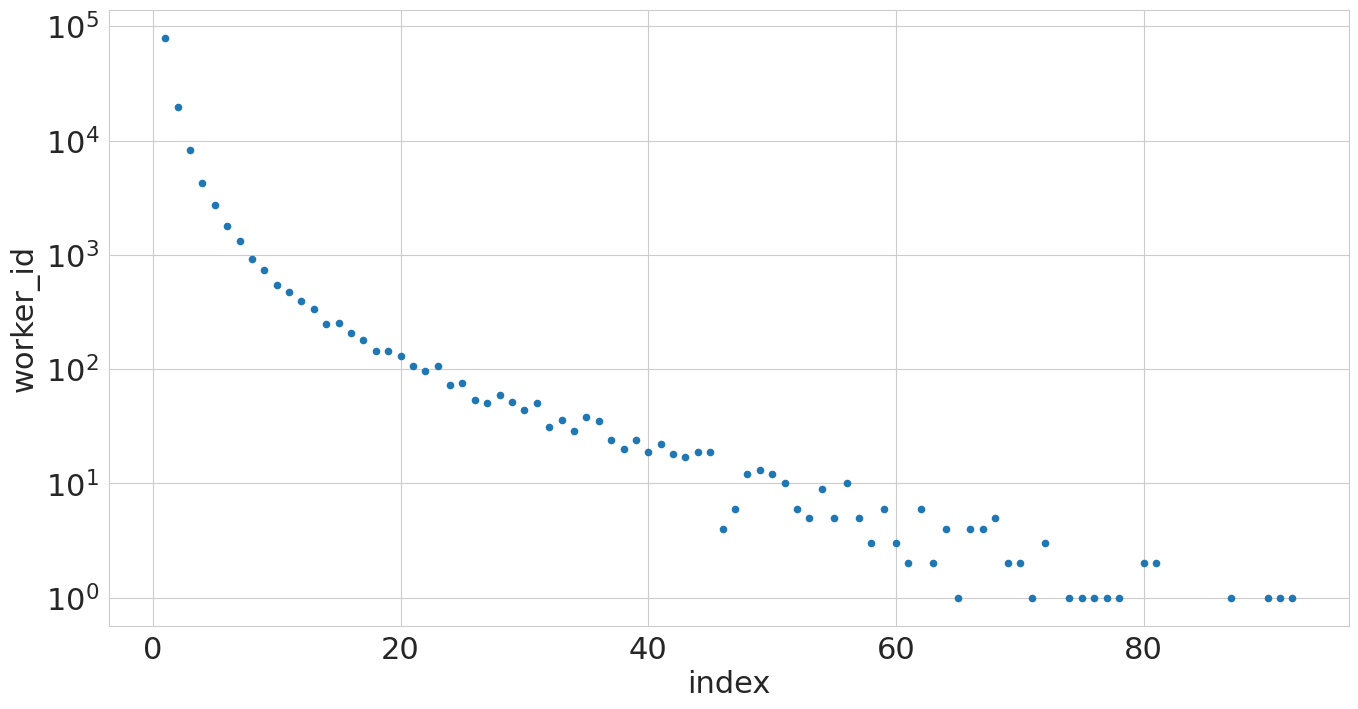

In [16]:
# Plot the above
df['worker_id'].value_counts().value_counts().sort_index().reset_index().plot.scatter(x='index', y='worker_id', logy=True)

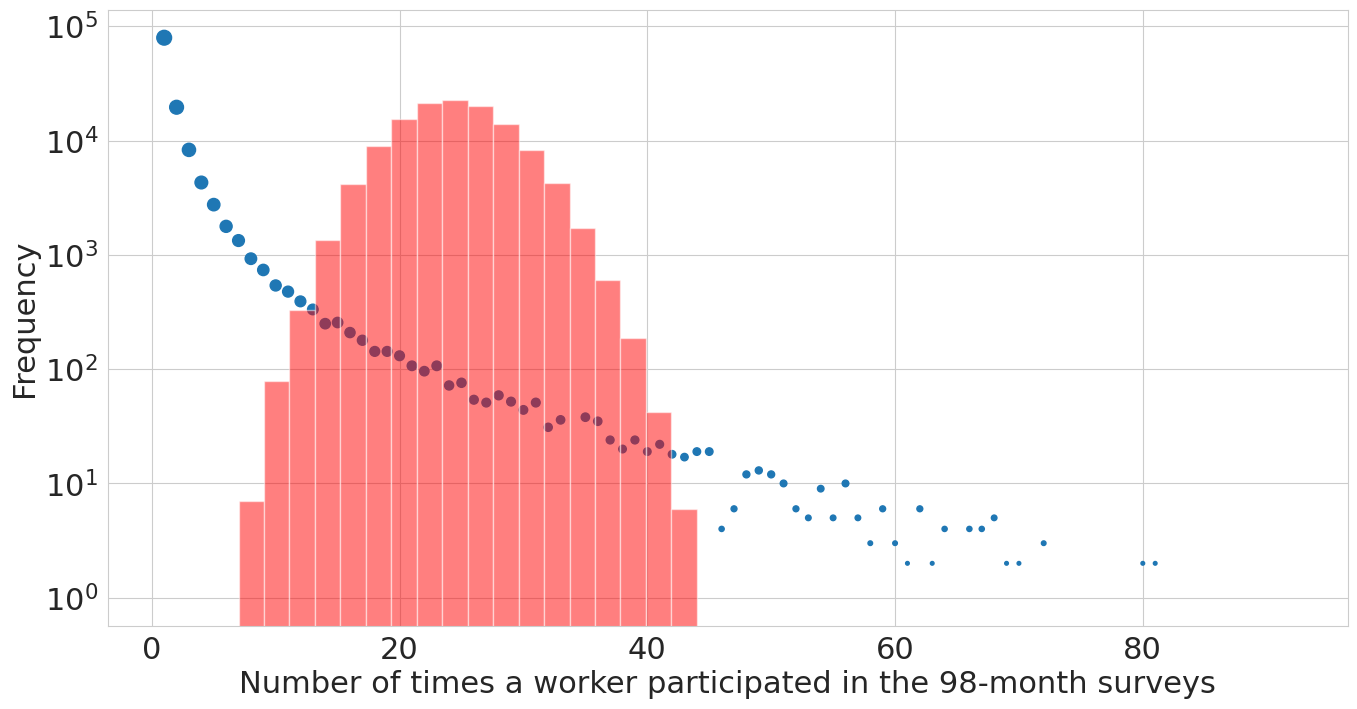

In [17]:
import numpy as np
import os
mpl.rc("figure", figsize=(16, 8))
mpl.rcParams.update({'font.size': 22})
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
sns.set_style("whitegrid")

from scipy.stats import binom
N=len(set(df['worker_id']))
p=0.25
rvs = binom.rvs(98, p, size=N)


fig, ax = plt.subplots(1, 1)

cnt = pd.DataFrame(x).drop(34).reset_index()
cnt['index'] = cnt['index'] # /cnt['index'].max()
ax = cnt.plot.scatter(x='index', y='worker_id', logy=True, logx=False, s=10*np.log(cnt['worker_id']), ax = ax)

ax.set_xlabel("Number of times a worker participated in the 98-month surveys")
ax.set_ylabel("Number of workers")

pd.DataFrame(rvs).plot.hist(alpha=0.5, color='r', bins=18, sharex=True, ax=ax)
ax.legend().set_visible(False)

if not os.path.exists('plots'):
    os.makedirs('plots')

plt.savefig('plots/frequency-counts.pdf', bbox_inches='tight')

(array([2.75723468e-05, 3.07234721e-04, 1.29196139e-03, 5.33327965e-03,
        1.63464627e-02, 3.55249994e-02, 6.03046613e-02, 8.41508024e-02,
        8.90468634e-02, 7.88490340e-02, 5.55149508e-02, 3.28307872e-02,
        1.68900319e-02, 6.74734715e-03, 2.38697745e-03, 7.44453363e-04,
        1.65434081e-04, 2.36334401e-05]),
 array([ 7.        ,  9.05555556, 11.11111111, 13.16666667, 15.22222222,
        17.27777778, 19.33333333, 21.38888889, 23.44444444, 25.5       ,
        27.55555556, 29.61111111, 31.66666667, 33.72222222, 35.77777778,
        37.83333333, 39.88888889, 41.94444444, 44.        ]),
 [<matplotlib.patches.Polygon at 0x7dd82f5d9d80>])

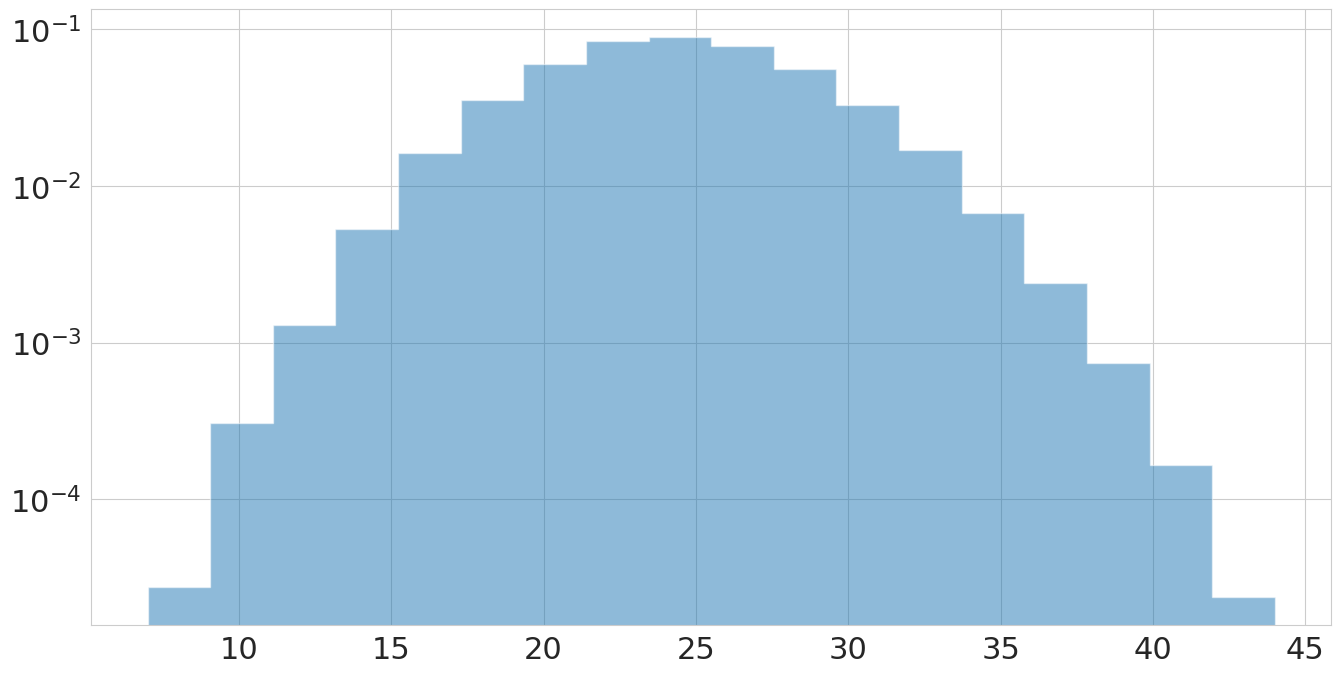

In [18]:
fig, ax = plt.subplots(1, 1)
ax.set_yscale("log")
ax.hist(rvs, density=True, histtype='stepfilled', alpha=0.5, bins=18)

In [19]:
# Let's try to fit directly a beta distribution on the counts:
import scipy
import random

data = []
mx_freq = max(x.index)
for i,v in x.iteritems():
    tmp = [i/mx_freq] * v
    data.extend(tmp)

random.shuffle(data)

scipy.stats.beta.fit(data, scale=1, loc=0)

<ipython-input-19-12697a23504c>:7: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i,v in x.iteritems():
/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


(0.5333706778568913,
 36.64712420092742,
 0.010869565217391302,
 1.0092637266807625)

In [20]:
# We can also try a variety of other distributions and find hte best fit.

import numpy as np
import scipy.stats as st
import statsmodels as sm
import warnings
import sys

# Create models from data
def best_fit_distribution(data, bins=27, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    '''
    DISTRIBUTIONS = [
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]
    '''
    DISTRIBUTIONS = [
        st.beta,st.expon,st.exponnorm,st.lognorm,st.lomax,st.powerlaw,st.powerlognorm,st.powernorm
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf
    #best_p = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:
        # print(distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data, fscale=1)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                #cdf = distribution.cdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                aic = 2*len(params) + np.sum ( distribution.logpdf(data, loc=loc, scale=scale, *arg) )
                #ks = st.kstest(y, cdf)

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

                print("{0}, [{1}], {2:3,.2f}, {3:3,.2f}".format(distribution.name, params, sse, aic))

        except Exception as e:
            print(sys.exc_info()[0])
            pass

    return (best_distribution.name, best_params)


In [21]:
# Find best fit distribution
best_fit_name, best_fit_paramms = best_fit_distribution(data, 27)
best_dist = getattr(st, best_fit_name)

print("===================")
print(best_fit_name, best_fit_paramms)

beta, [(0.5952226874364936, 67.93883482718687, 0.010869565217391302, 1)], 161.47, 1,506,767.07
expon, [(0.010869565217391304, 1.0)], 569.60, -1,821.41
exponnorm, [(5.600528532650006e-05, 0.02556114343251091, 1)], 592.52, -113,610.54
lognorm, [(7.233835379496761, 0.010869565217391302, 1)], 488.49, 1,780,187.35
lomax, [(72.09871231429094, 0.010869565217376871, 1)], 31.10, 403,152.30
powerlaw, [(0.03617428954971786, 0.010869565217391302, 1)], 528.10, 2,880,749.52
powerlognorm, [(2.0438624349470516, 5.6851384509994745, 0.010869565217382117, 1)], 404.70, 1,184,776.58
powernorm, [(255809271.90851432, 5.812646072946279, 1)], 513.87, 86,696.43
lomax (72.09871231429094, 0.010869565217376871, 1)


In [22]:
# This is from Chao 1987, equation 10.
# This provides a lower bound on the population
# The assumptions in that paper, for the derivation of this estimator are still not great
# as it assumes that the number of captures (sample periods) is large and that probability
# of capture (propensity) is small. This does not work for the right tail (the heavy hitters)

S = len(set(df['worker_id'])) # 37830 123508
f1 = cnt.loc[0]['worker_id'] # 25070 79469
f2 = cnt.loc[1]['worker_id'] # 5642 19584
f3 = cnt.loc[2]['worker_id'] # 2346 8297
t = len(cnt.index) # 27 82
m1 = 2 * f2/f1
m2 = 6* f3/f1

N = S + f1**2 / (2*f2) * (( 1 - m1/t)/(1-m2/(t*m1)))
N

286298.87152284285

In [23]:
f3

8297

In [53]:
# Let's compute the frequency of captures
f = df['worker_id'].value_counts().value_counts()
# f = f.drop(34) # dropping the outlier, this is a data point that should not have existed

In [54]:
# If we assume that the distribution of the propensities follows a Beta distribution,
# then the counts will follow a Beta-Binomial distribution
# See https://en.wikipedia.org/wiki/Beta-binomial_distribution


In [26]:
from scipy.special import gammaln
import numpy as np
def beta_binom_density_ln(k, n, alpha, beta):
    Ad = beta
    Bd = alpha
    An = n - k + beta
    Bn = k + alpha
    num = gammaln(An) + gammaln(Bn) - gammaln(An+Bn)
    den = gammaln(Ad) + gammaln(Bd) - gammaln(Ad+Bd)
    log = np.log(scipy.special.comb(n,k)) + num - den
    return np.exp(log)

In [27]:
# Using the method of moments, we can try to fit directly:
# See https://en.wikipedia.org/wiki/Beta-binomial_distribution#Point_estimates

t = max(f.index)
distinct = sum ( [f[i] for i in f.index] )
m1 = sum([ i * f[i] for i in f.index]) / distinct
m2 = sum([ i*i * f[i] for i in f.index]) / distinct
# print(m1, m2)
a = (t * m1 - m2) / (( t * (m2/m1) - m1 -1 ) + m1)
print(a)

b = (t - m1) * ( t  - m2/m1) / (( t * (m2/m1) - m1 -1 ) + m1)
print(b)

0.2256680432149409
8.572512187113213


In [28]:
# This is the probability that a user from the population
# is sampled 0 times
# The one beloe is with the parameters estimated using the method of moments
beta_binom_density_ln(0, t, a, b)

0.5683070300848898

In [38]:
t=98

In [55]:
# The one below is estimated through fitting on the MLE estimates for each user
beta_binom_density_ln(0, t, 0.60, 67.9)

0.5844682972606422

In [56]:
distinct

123507

In [57]:
# We now need to estimate the value of f[0], which is the number of workers that we have not seen
# That is equal to  beta_binom_density_ln(0, t, a, b) * N
# The remaining workers that we have seen is distinct = N * ( 1-  beta_binom_density_ln(0, t, a, b))

N  = distinct / (1 - beta_binom_density_ln(0, t, 0.60, 67.9))
print(N)

297226.41903323017


In [58]:
## These are additional estimates based on the difference of the count vs the expected count
## for various frequencies

import scipy.special
import math

# Fitting on the MLE estimate for each user
a = 0.60
b = 67.9

# Fitting using Method of Moments for Beta-Binomial
# a = 0.3
# b = 4.6

N_approx = dict()
sm, cn = 0.0, 0.0
for i in f.index:
    #print("==========================")
    # e_fi = scipy.special.comb(t, i) * scipy.special.beta(a+i, t-i+b) / scipy.special.beta(a, b)
    e_fi = beta_binom_density_ln(i, t, a, b)
    # print(st.beta.moment(i, a, b))
    # print(e_fi)
    N_approx[i] = f[i]  / e_fi
    print("N_{i:02d} = {approx:10,.2f}". format(i=i, approx=N_approx[i]))
    sm += N_approx[i]
    cn += 1
    print("Avg = {approx:10,.2f}". format(approx=sm/cn))



N_01 = 381,311.69
Avg = 381,311.69
N_02 = 198,472.80
Avg = 289,892.25
N_03 = 164,633.59
Avg = 248,139.36
N_04 = 161,489.58
Avg = 226,476.92
N_05 = 192,383.09
Avg = 219,658.15
N_06 = 228,841.41
Avg = 221,188.69
N_07 = 314,933.34
Avg = 234,580.79
N_08 = 398,993.20
Avg = 255,132.34
N_09 = 580,143.40
Avg = 291,244.68
N_10 = 774,564.58
Avg = 339,576.67
N_11 = 1,249,792.22
Avg = 422,323.54
N_12 = 1,879,525.09
Avg = 543,757.00
N_13 = 2,928,789.34
Avg = 727,221.03
N_15 = 7,644,695.65
Avg = 1,221,326.36
N_14 = 4,044,938.16
Avg = 1,409,567.14
N_16 = 11,560,734.98
Avg = 2,044,015.13
N_17 = 18,412,547.02
Avg = 3,006,869.95
N_18 = 27,468,811.42
Avg = 4,365,866.70
N_19 = 51,524,327.65
Avg = 6,847,890.96
N_20 = 88,950,770.93
Avg = 10,953,034.96
N_23 = 501,146,945.20
Avg = 34,295,602.11
N_21 = 137,590,375.41
Avg = 38,990,819.08
N_22 = 234,971,132.13
Avg = 47,511,702.25
N_25 = 1,325,254,988.80
Avg = 100,751,005.86
N_24 = 648,834,862.63
Avg = 122,674,360.13
N_28 = 7,726,322,782.84
Avg = 415,122,376.39
N

In [59]:
del N_approx[29]
del N_approx[34]


In [60]:
print(sum(N_approx.values())/len(N_approx))

1.81379393222419e+38


In [61]:
sorted(N_approx.values())[13]

4044938.1574196112

In [47]:
from scipy.special import logit

## Regression against the demographics:

tmp = df.set_index('worker_id').drop(
    ['hit_answered_date','hit_creation_date','location_city','location_region','date','time'],axis=1)

# How often do we see each worker?
dem_df = pd.DataFrame(df['worker_id'].value_counts()).merge(
    tmp,
    how='inner', left_index=True, right_index=True)

dem_df = dem_df [ dem_df.worker_id < 30]
dem_df['propensity'] = logit(dem_df['worker_id']/30)
dem_df['location_country'] = dem_df['location_country'].apply(lambda x : x if x in ['US','IN','CA','GB','PH'] else 'OTHER')
dem_df['age'] = 2017-dem_df['year_of_birth']
dem_df.drop('year_of_birth',axis=1,inplace=True)
dem_df.drop_duplicates(inplace=True)

len(dem_df)

183931

In [48]:
dem_df

,worker_id,gender,household_size,household_income,marital_status,time_spent_on_mturk,languages_spoken,weekly_income_from_mturk,educational_level,location_country,propensity,age
++02UODwxdYWf9ZrGzadGzqDSs6QFkzbErnxTVWRPX0=,6,male,1,"$25,000-$39,999",single,NaN,NaN,NaN,NaN,US,-1.386294,24.0
++02UODwxdYWf9ZrGzadGzqDSs6QFkzbErnxTVWRPX0=,6,male,1,"$25,000-$39,999",single,1-2 hours per week,English,$5-$10 per week,"Some college, no degree",US,-1.386294,24.0
++02UODwxdYWf9ZrGzadGzqDSs6QFkzbErnxTVWRPX0=,6,male,1,"$15,000-$24,999",single,20-40 hours per week,English,$100-$200 per week,"Some college, no degree",US,-1.386294,24.0
++0FHBqur6ccgrVRWaML3i4Wei72uNDuWkEGKpx8hA8=,1,male,4,"Less than $10,000",married,20-40 hours per week,Tamil,$20-$50 per week,Bachelors degree,IN,-3.367296,37.0
++1gpM2LP7ebtNGeNb3YkjprnKK02swy5CIAWoX64zE=,1,male,2,"$10,000-$14,999",single,2-4 hours per week,English,$5-$10 per week,Bachelors degree,US,-3.367296,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...
zzkXv+6/POSSIgwrpa0Yneac9HYW5Rg1Yr7FPvU0O5Y=,1,female,1,"$60,000-$74,999",married,NaN,NaN,NaN,NaN,US,-3.367296,28.0
zzmWbq2MtBJlOQb0OzqTh9QdDrsQgtqp6J3VChJAXPg=,1,female,4,"$10,000-$14,999",married,1-2 hours per week,English,$1-$5 per week,Bachelors degree,US,-3.367296,53.0
zzvROB3J9BDs83jlcaHmqx8rky0FqkG5TeIhQfXF1Rw=,3,male,2,"Less than $10,000",married,4-8 hours per week,English,$1-$5 per week,Some High School,IN,-2.197225,23.0
zzvROB3J9BDs83jlcaHmqx8rky0FqkG5TeIhQfXF1Rw=,3,male,3,"Less than $10,000",single,4-8 hours per week,English,$10-$20 per week,Some High School,IN,-2.197225,22.0


In [49]:
dem_df.dtypes

worker_id                      int64
gender                        object
household_size              category
household_income            category
marital_status              category
time_spent_on_mturk           object
languages_spoken              object
weekly_income_from_mturk      object
educational_level             object
location_country              object
propensity                   float64
age                          float64
dtype: object

In [50]:
import math
import statsmodels.formula.api as sm

formula = "propensity ~ C(location_country) + C(gender) +  C(household_income)+ C(household_size) + C(marital_status) + age"

result = sm.ols(formula=formula, data=dem_df).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             propensity   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     822.6
Date:                Sun, 20 Aug 2023   Prob (F-statistic):               0.00
Time:                        10:26:28   Log-Likelihood:            -3.0876e+05
No. Observations:              183831   AIC:                         6.176e+05
Df Residuals:                  183804   BIC:                         6.178e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                   -3.3621      1.298     -2.590      0.010      -5.907      -0.818
C(location_country)[T.GB]                   -0.2981      0.034     -8.757      0.000      -0.365      -0.231
C(location_country)[T.IN]                    1.4777      0.025     58.087      0.000       1.428       1.528
C(location_country)[T.OTHER]                 0.3688      0.026     14.131      0.000       0.318       0.420
C(location_country)[T.PH]                    0.5489      0.068      8.070      0.000       0.416       0.682
C(location_country)[T.US]                    0.2369      0.024      9.816      0.000       0.190       0.284
C(gender)[T.female]                          0.9696      1.298      0.747      0.455      -1.574       3.514
C(gender)[T.male]                            0.9537      1.298      0.735      0.462      -1.590       3.498
C(household_income)[T.$100,000 or more]      0.1984      0.015     13.150      0.000       0.169       0.228
C(household_income)[T.$15,000-$24,999]       0.0971      0.014      6.897      0.000       0.070       0.125
C(household_income)[T.$25,000-$39,999]       0.1139      0.013      8.629      0.000       0.088       0.140
C(household_income)[T.$40,000-$59,999]       0.1170      0.013      9.069      0.000       0.092       0.142
C(household_income)[T.$60,000-$74,999]       0.1461      0.014     10.459      0.000       0.119       0.173
C(household_income)[T.$75,000-$99,999]       0.1335      0.014      9.444      0.000       0.106       0.161
C(household_income)[T.Less than $10,000]    -0.0602      0.014     -4.173      0.000      -0.089      -0.032
C(household_size)[T.2]                      -0.1048      0.011     -9.153      0.000      -0.127      -0.082
C(household_size)[T.3]                      -0.1733      0.011    -15.362      0.000      -0.195      -0.151
C(household_size)[T.4]                      -0.2029      0.011    -17.656      0.000      -0.225      -0.180
C(household_size)[T.5 ]                      0.3459      0.649      0.533      0.594      -0.926       1.618
C(household_size)[T.5+]                     -0.1246      0.013     -9.482      0.000      -0.150      -0.099
C(marital_status)[T.divorced]               -0.1161      0.020     -5.853      0.000      -0.155      -0.077
C(marital_status)[T.engaged]                -0.2643      0.021    -12.446      0.000      -0.306      -0.223
C(marital_status)[T.married]                -0.2950      0.013    -23.300      0.000      -0.320      -0.270
C(marital_status)[T.separated]               0.8089      0.918      0.881      0.378      -0.990       2.608
C(marital_status)[T.single]                 -0.1120      0.013     -8.420      0.000      -0.138      -0.086
C(marital_status)[T.widowed]   

<Axes: ylabel='Frequency'>

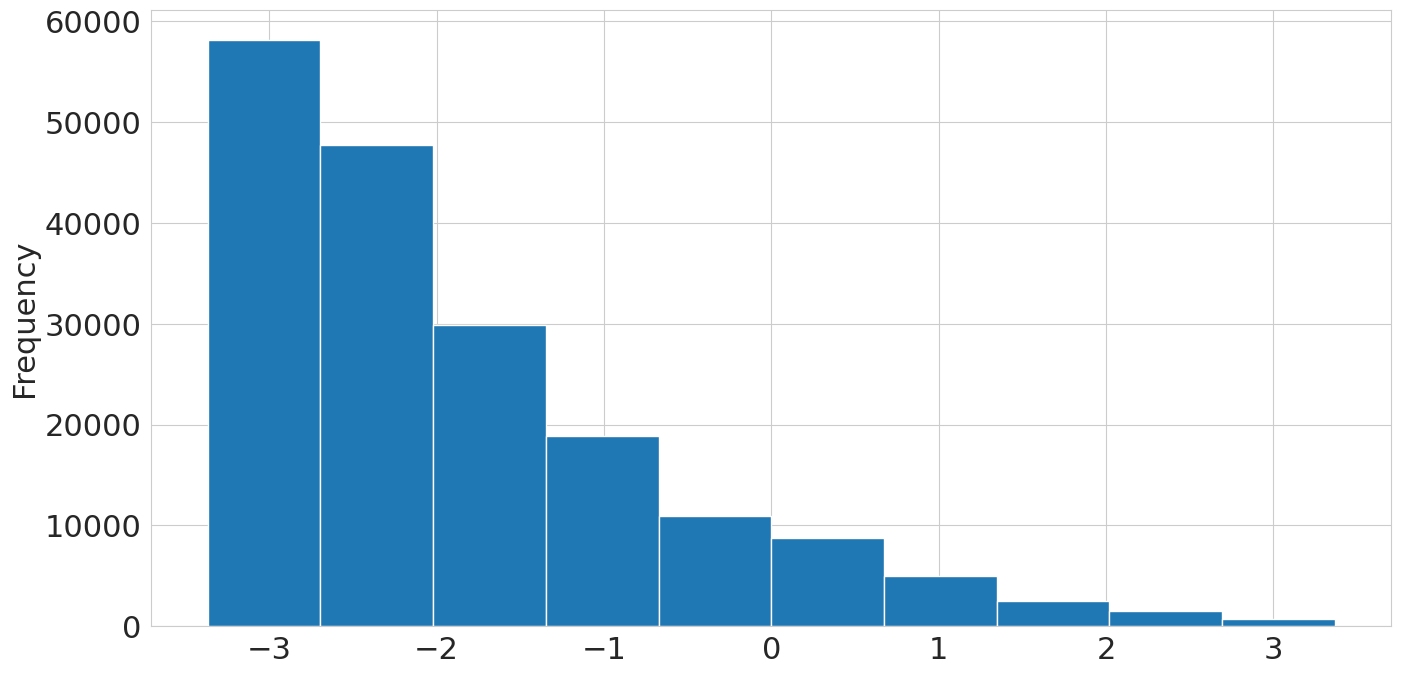

In [51]:
dem_df.propensity.plot.hist()

In [52]:
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.cov_struct import (Exchangeable,
    Independence,Autoregressive)
from statsmodels.genmod.families import Poisson

fam = Poisson()
ind = Independence()
model1 = GEE.from_formula(formula, data=dem_df, cov_struct=ind, family=fam)
result1 = model1.fit()
result1.summary()

TypeError: ignored

In [ ]:
!sudo pip3 install -U pymc3

In [ ]:
import pymc3 as pm

with pm.Model() as model:
    pm.glm.GLM.from_formula(formula=formula, data=dem_df, family=pm.glm.families.NegativeBinomial())

    # Old initialization
    # start = pm.find_MAP(fmin=optimize.fmin_powell)
    # C = pm.approx_hessian(start)
    # trace = pm.sample(4000, step=pm.NUTS(scaling=C))

    trace = pm.sample(2000, njobs=2)